In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras._tf_keras.keras.layers import Dense, Input
from keras._tf_keras.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [3]:
df0 = pd.read_csv('ETH-USD.csv', index_col='Date', parse_dates=True)

In [4]:
df = df0[['Close']].copy()

In [5]:
df['LogClose'] = np.log(df['Close'])

In [6]:
df['DiffLogClose'] = df['LogClose'].diff()

In [7]:
df.head()

,Close,LogClose,DiffLogClose
Date,,,
2019-05-29,269.455688,5.596404,NaN
2019-05-30,255.858948,5.544626,-0.051778
2019-05-31,268.113556,5.591411,0.046784
2019-06-01,265.391266,5.581205,-0.010205
2019-06-02,270.225525,5.599257,0.018052


In [8]:
Ntest = 21
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [9]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['DiffLogClose']])
test_scaled = scaler.fit_transform(test[['DiffLogClose']])

In [10]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [11]:
df.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
df.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()

In [12]:
df.head()

,Close,LogClose,DiffLogClose,ScaledLogReturn
Date,,,,
2019-05-29,269.455688,5.596404,NaN,NaN
2019-05-30,255.858948,5.544626,-0.051778,-1.186557
2019-05-31,268.113556,5.591411,0.046784,1.015582
2019-06-01,265.391266,5.581205,-0.010205,-0.257721
2019-06-02,270.225525,5.599257,0.018052,0.373618


In [13]:
# Make supervised dataset
series  = df['ScaledLogReturn'].dropna().to_numpy()

T = 10
X = []
Y = []
q = True
for t in range(len(series) - T):
    x = series[t: t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    if q:
        q = False
        print('X',X,'Y',Y)
X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print('X.shape', X.shape, 'Y.shape', Y.shape)

X [array([-1.18655732,  1.01558166, -0.2577214 ,  0.37361756, -1.53601173,
       -1.04935576,  0.49295969,  0.18838627,  0.10031567, -0.49687142])] Y [-1.2106470652989456]
X.shape (1817, 10) Y.shape (1817,)


In [15]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [16]:
# Basic AMM
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(inputs=i, outputs=x)

In [17]:
model.compile(loss='mse', optimizer='adam')

In [18]:
r = model.fit(Xtrain, Ytrain, epochs=200, validation_data=(Xtest, Ytest))

Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1394 - val_loss: 1.0497
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9741 - val_loss: 1.0392
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9229 - val_loss: 1.0457
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9017 - val_loss: 1.0515
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8895 - val_loss: 1.0563
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8805 - val_loss: 1.0589
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8732 - val_loss: 1.0619
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8667 - val_loss: 1.0646
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8613 - val_loss: 1.0680
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8569 - val_loss: 1.0706
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8532 - val_loss: 1.0737
Epoch 12/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8

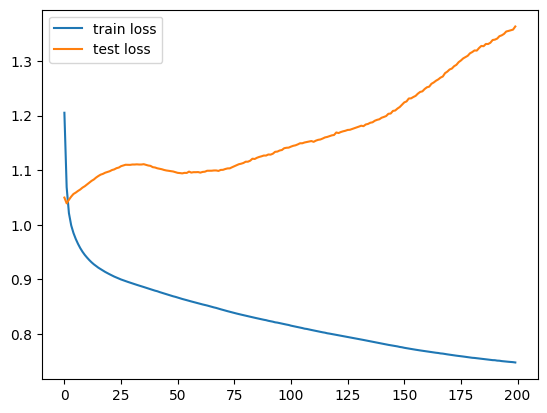

In [20]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

In [21]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [22]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [23]:
df.loc[train_idx,'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx,'Diff ANN Test Prediction'] = Ptest

In [24]:
df.head()

,Close,LogClose,DiffLogClose,ScaledLogReturn,Diff ANN Train Prediction,Diff ANN Test Prediction
Date,,,,,,
2019-05-29,269.455688,5.596404,NaN,NaN,NaN,NaN
2019-05-30,255.858948,5.544626,-0.051778,-1.186557,NaN,NaN
2019-05-31,268.113556,5.591411,0.046784,1.015582,NaN,NaN
2019-06-01,265.391266,5.581205,-0.010205,-0.257721,NaN,NaN
2019-06-02,270.225525,5.599257,0.018052,0.373618,NaN,NaN


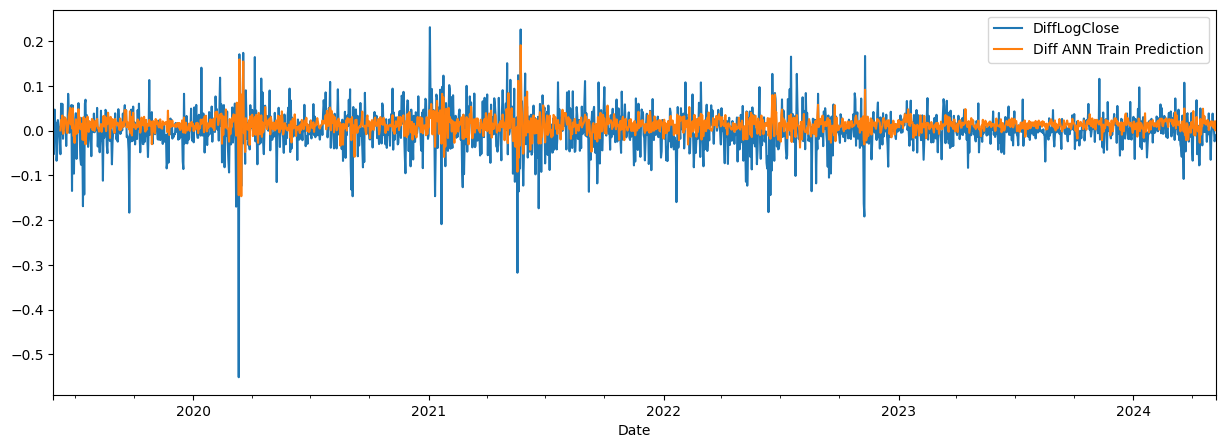

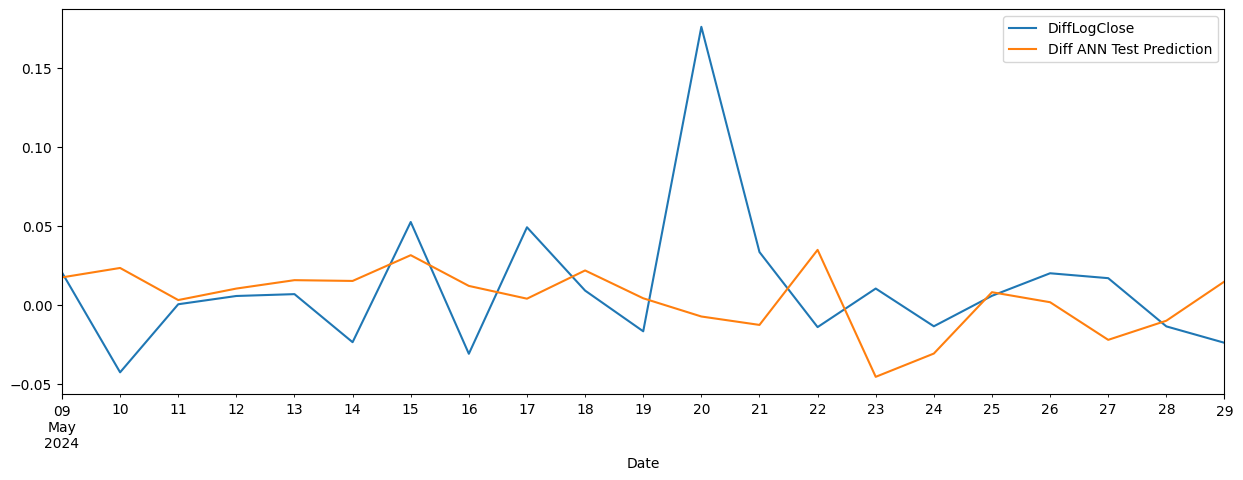

In [28]:
cols1 = ['DiffLogClose', 'Diff ANN Train Prediction']
cols2 = ['DiffLogClose', 'Diff ANN Test Prediction']
df[cols1][:-Ntest].plot(figsize=(15,5));
df[cols2][-Ntest:].plot(figsize=(15,5));

In [29]:
# Undifferenced predictions
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

In [30]:
last_train = train.iloc[-1]['LogClose']

In [31]:
df.loc[train_idx,'1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx,'1step_test'] = prev[test_idx] + Ptest

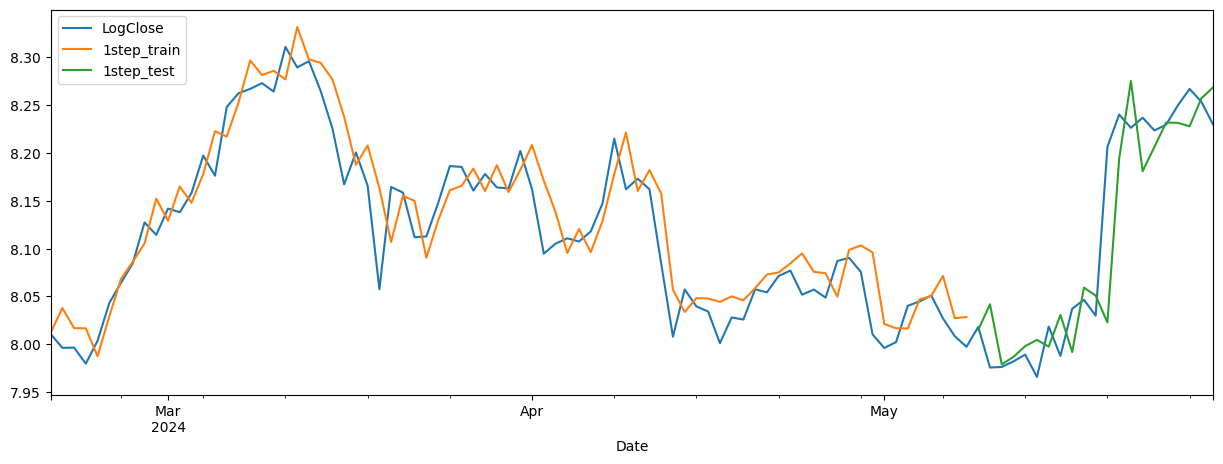

In [32]:
# plot 1-step forecast
df.iloc[-100:][['LogClose','1step_train','1step_test']].plot(figsize=(15,5));

In [33]:
# multistep forecast
multistep_predictions = []

last_x = Xtest[0]
while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1,-1))[0]
    
    multistep_predictions.append(p)
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Program Files\KMSpico\temp\ipykernel_16236\3235601641.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_x[-1] = p


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [34]:
multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler.inverse_transform(multistep_predictions.reshape(-1,1)).flatten()

In [35]:
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

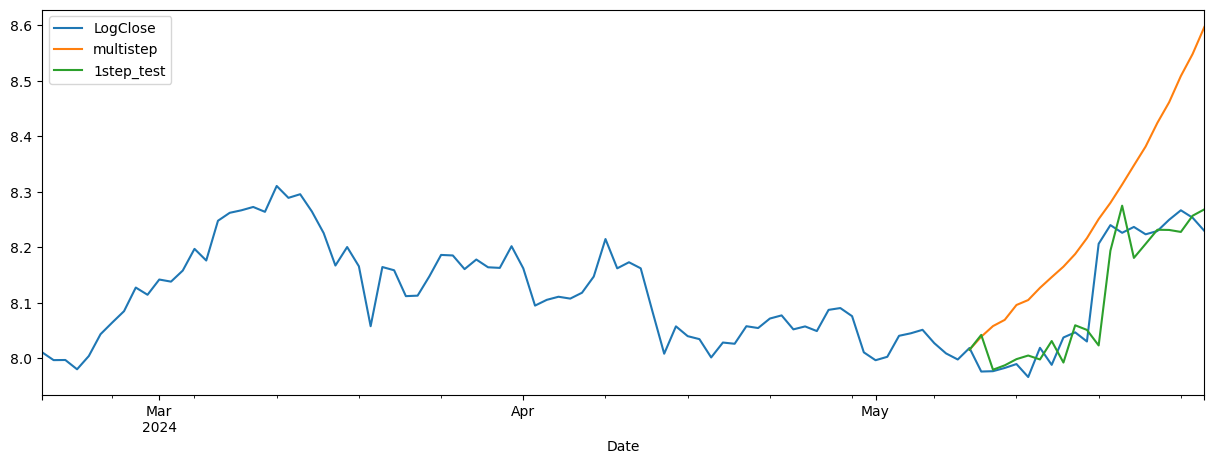

In [36]:
df.iloc[-100:][['LogClose', 'multistep', '1step_test']].plot(figsize=(15,5));

In [37]:
# multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
q = True
for t in range(len(series) - Tx - Ty +1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)
    if q:
        q = False
        print('X',X,'Y',Y)
X = np.array(X).reshape(-1,Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print('X.shape',X.shape,'Y.shape',Y.shape)

X [array([-1.18655732,  1.01558166, -0.2577214 ,  0.37361756, -1.53601173,
       -1.04935576,  0.49295969,  0.18838627,  0.10031567, -0.49687142])] Y [array([-1.21064707,  1.31267485, -0.1871683 ,  1.30427671, -0.4388722 ,
        0.65049034,  0.38369787, -0.01277847,  0.39185406, -0.8001535 ,
        0.33648696,  0.15718822,  1.8021947 ,  1.0405123 , -0.14210697,
        0.15799115,  0.51785148,  1.24163226, -3.04285292,  1.22215513,
        0.59556289])]
X.shape (1797, 10) Y.shape (1797, 21)


In [38]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [39]:
# Basic ANN
i = Input(shape=(Tx,))
x = Dense(32,activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i,x)

In [40]:
model.compile(loss='mse', optimizer='adam')

In [41]:
r = model.fit(Xtrain_m, Ytrain_m, epochs=100, validation_data=(Xtest_m,Ytest_m))

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2447 - val_loss: 1.0256
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0962 - val_loss: 1.0256
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0541 - val_loss: 1.0197
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0325 - val_loss: 1.0124
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0195 - val_loss: 1.0071
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0109 - val_loss: 1.0032
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0047 - val_loss: 0.9991
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0001 - val_loss: 0.9950
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9966 - val_loss: 0.9922
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9937 - val_loss: 0.9904
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9913 - val_loss: 0.9884
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9

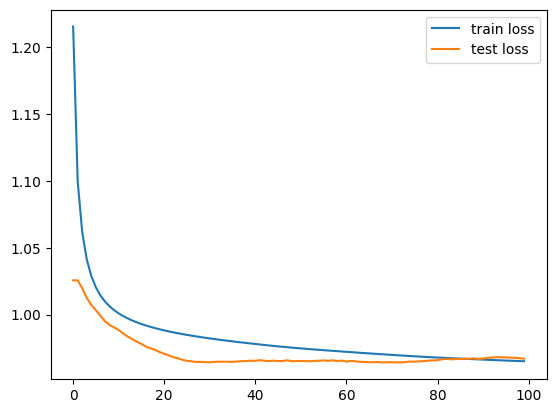

In [42]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [43]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [44]:
Ptrain.shape, Ptest.shape

((1796, 21), (21, 21))

In [45]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [46]:
Ptest = scaler.inverse_transform(Ptest.reshape(-1,1)).flatten()

In [47]:
df.loc[test_idx,'multioutput'] = last_train + np.cumsum(Ptest)

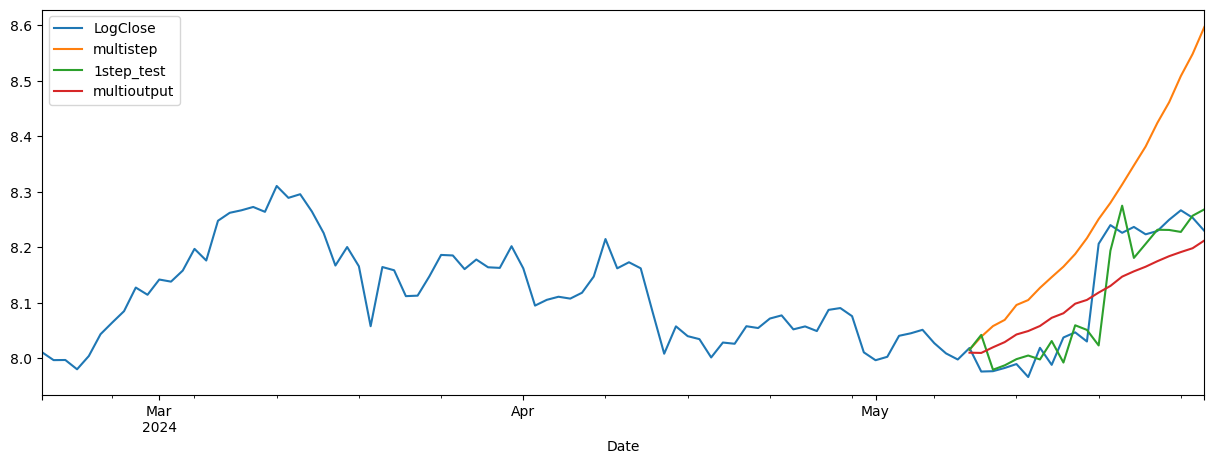

In [48]:
cols = ['LogClose', 'multistep', '1step_test', 'multioutput']
df.iloc[-100:][cols].plot(figsize=(15,5));

In [49]:
test_log_pass = df.iloc[-Ntest:]['LogClose']
mape1 = mean_absolute_percentage_error(test_log_pass,df.loc[test_idx,'multistep'])
print('Multi-step MAPE:', mape1)
mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx,'multioutput'])
print('Multi-output MAPE:',mape2)

Multi-step MAPE: 0.017275484230821925
Multi-output MAPE: 0.00729822815254968


## 1-step Binary Classification

In [50]:
Ytrain_b = (Ytrain > 0) * 1
Ytest_b = (Ytest > 0) * 1

In [51]:
# Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i,x)

In [52]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])

In [53]:
r = model.fit(Xtrain, Ytrain_b, epochs=100, validation_data=(Xtest,Ytest_b))

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5035 - loss: 0.7247 - val_accuracy: 0.6667 - val_loss: 0.7054
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5218 - loss: 0.7043 - val_accuracy: 0.6667 - val_loss: 0.6877
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5194 - loss: 0.6981 - val_accuracy: 0.6190 - val_loss: 0.6811
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5168 - loss: 0.6942 - val_accuracy: 0.6667 - val_loss: 0.6781
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5190 - loss: 0.6911 - val_accuracy: 0.6667 - val_loss: 0.6767
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5248 - loss: 0.6885 - val_accuracy: 0.6667 - val_loss: 0.6753
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5248 - loss: 0.6861 - val_accuracy: 0.6667 - val_loss: 0.6740
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5260 - loss: 0.6840 - val_accuracy: 0.6667 - 

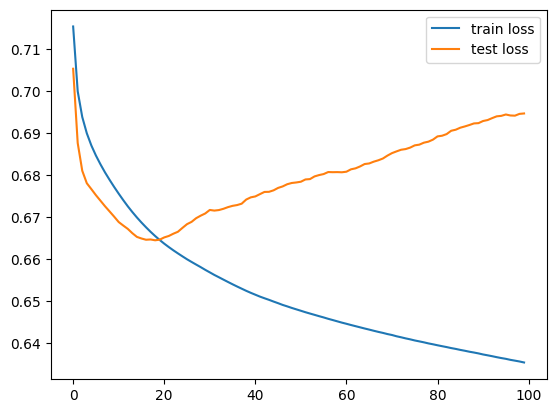

In [54]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

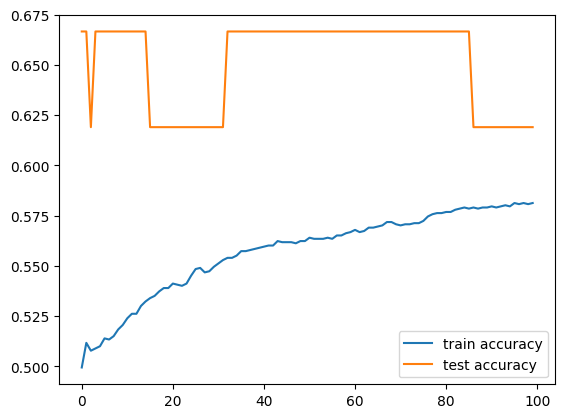

In [55]:
plt.plot(r.history['accuracy'],label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend();